# SEP on f105w band image of the Hubble Ultra Deep Field

Altered from: https://sep.readthedocs.io/en/v1.0.x/tutorial.html 

In [2]:
# import all the packages we need
import numpy as np
import sep

#for reading the image
from astropy.io import fits

#for displaying plots
import matplotlib.pyplot as plt
from matplotlib import rcParams
# %matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Then we open the fits test image and display it, so that we can see what info we're dealing with.

In [3]:
# open fits file and read image data 
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data

# it's a standard numpy array
# type(data)
    

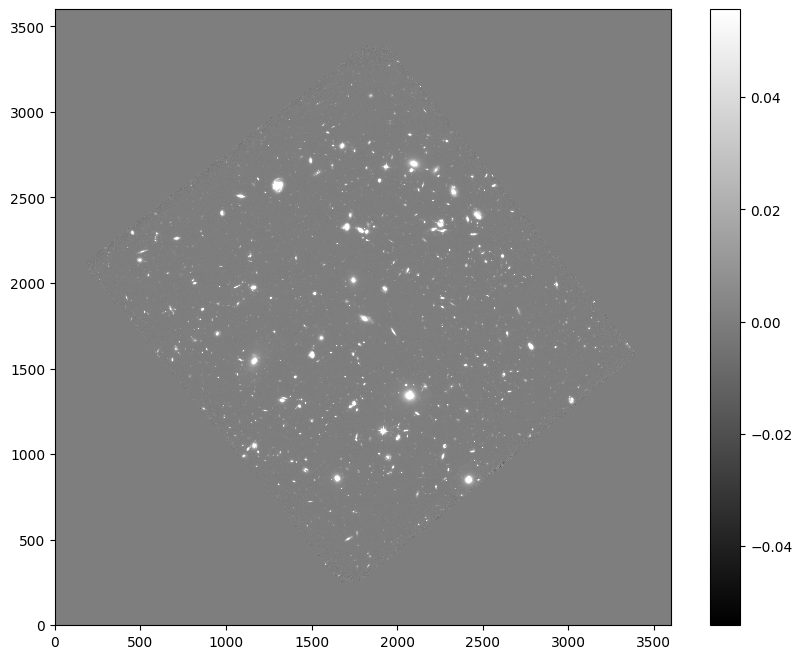

In [4]:
# show the image
m, s = np.mean(data), np.std(data) #get the mean and std

#imshow takes the image data, type of interpolation (estimation), a color map type,
#the data range that the color map covers (vmin to vmax)*,
#and where to place start the data from [0,0] of the image array
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#display a colorbar
plt.colorbar();

# *here they are calculated by +/- one std from the mean

plt.savefig('f105w-HUDF.png', bbox_inches='tight')

## Background Subtraction

Measure the background of the image.

In [5]:
# Fix byte order
data = data.byteswap().newbyteorder()

bkg = sep.Background(data) #Returns a 'Background' object

Evaluate the background as a 2-d array the same size as the original image

In [6]:
bkg_image = bkg.back()# bkg_image = np.array(bkg) is equivalent

Show the background as an image

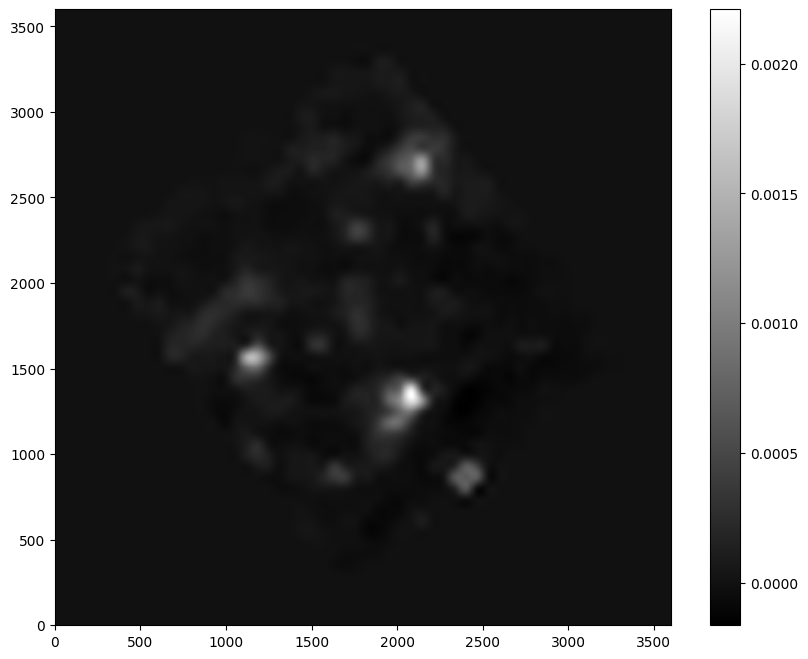

In [7]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

# save the figure as png
plt.savefig('f105w-HUDF-background.png', bbox_inches='tight')

- Evaluate the background noise as a 2-d array the same size as the original image

In [8]:
bkg_rms = bkg.rms()

- Show the background noise as an image from the 2-d array we just created

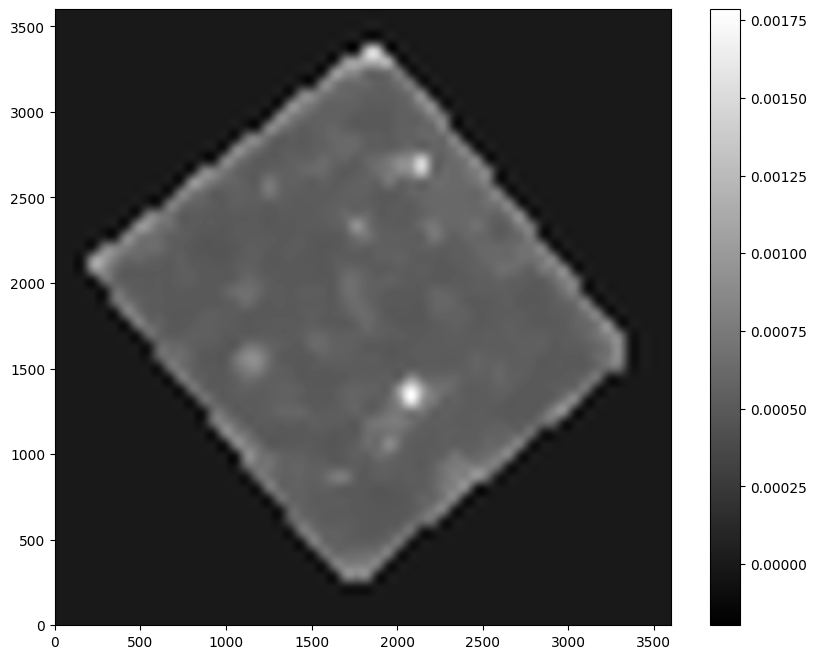

In [9]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

# save image
plt.savefig('f105w-HUDF-background-noise.png', bbox_inches='tight')

- Subtract the background we computed from the original data 
    - Note: If the data array is not background subtracted well or the threshold is too low, it can cause exceptions to be raised or it can cause one giant object to be extracted when using sep.extract on the newly subtracted data

In [10]:
# subtract the background
data_sub = data - bkg # In-place version: bkd.subfrom(data)

## Object Detection

After the background has been subtracted, we can now run object detection on the background-subtracted data.

Because the background noise level in the example is relatively flat, the detection threshold can be set to the constant value 1.5*sigma where sigma is the gobal background RMS (which was calculated above)

In [51]:
objects = sep.extract(data_sub, 3, err=bkg.globalrms, minarea=5) #Returns a structed np array

#view how many objects were detected
print(len(objects))

4343


sep.extract has a lot of options for controlling the detection threshold such as pixel masking, filtering, and obect deblending, info on which is available in the reference documentation.

objects['x'] and objects['y'] give the centroid coordinates (center point of the object).

The following cell over-plots the object coordinates using matplotlib.patches Ellispe onto the original image.

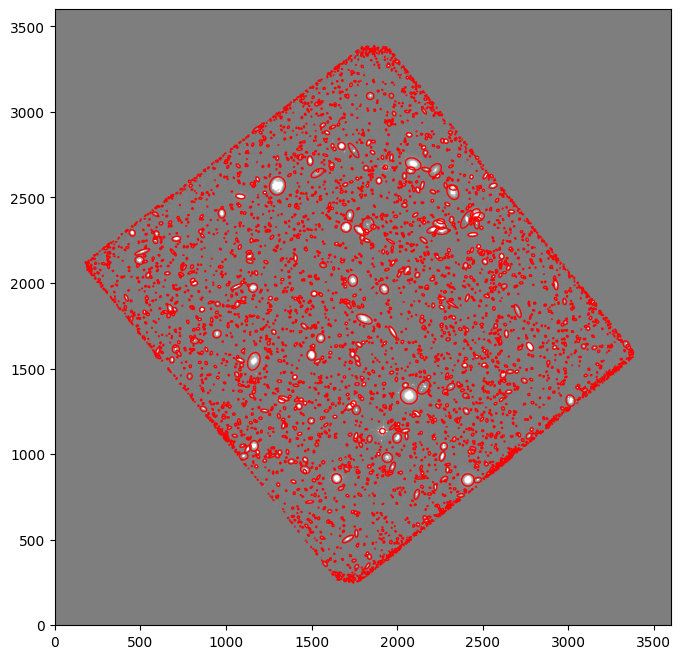

In [52]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e) #add the ellipse to the axes

plt.savefig('f105w-HUDF-identified-objects.png', bbox_inches='tight')

## Aperture Photometry

The final step is to perform 'simple circular aperture photometry with a 3 pixel radius at the locations of the objects'.

*flux, fluxerr, and flag are all 1-d arrays with one entry per object found

In [54]:
# sep.sumcircle takes the subtracted data, the x, y locations of the located objects, 
# a pixel radius of the aperature, an error, and a gain*
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

# * gain : float, optional
#       Conversion factor between data array units and poisson counts,
#       used in calculating poisson noise in aperture sum

## Histogram the fluxes

In [55]:
print(f"{len(flux)} sources were found.")


4343 sources were found.


In [56]:
#create the histogram bins
width = .01
histmin =  np.round(min(flux), 1) #round to closest tenth
histmax =  np.round(max(flux), 1) #round to closest tenth

print(histmin, min(flux), histmax, max(flux))

-1.2 -1.206750793821887 807.1 807.1093853378296


In [57]:
bins = np.arange(histmin, histmax, width)

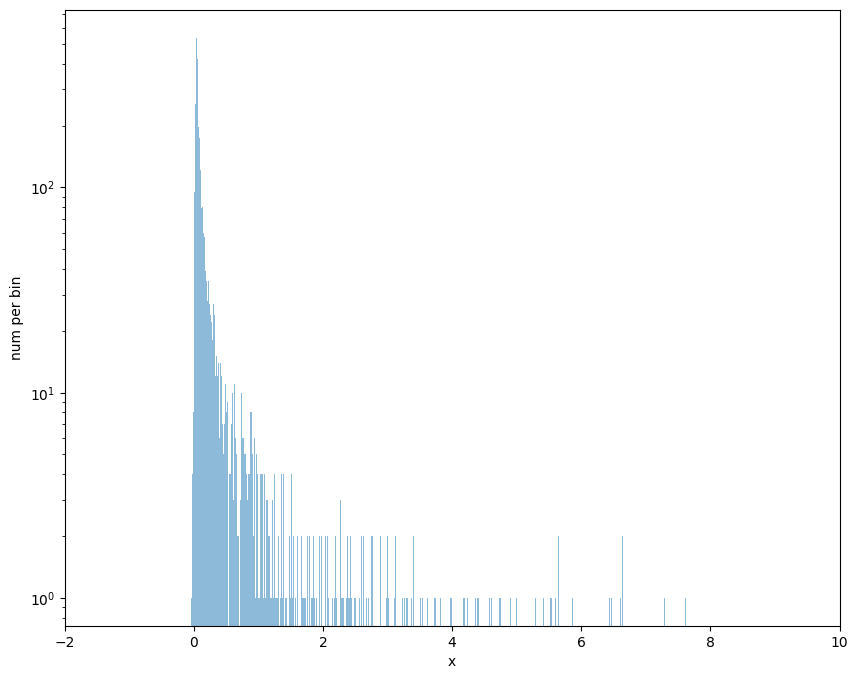

In [58]:

#create historgram
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.hist(flux, bins = bins, alpha = 0.5)

ax.set_yscale('log')
# ax.set_ylim(ymax = 2000)
ax.set_xlim(xmin= -2, xmax = 10)

plt.xlabel('x')
plt.ylabel('num per bin')
plt.show()

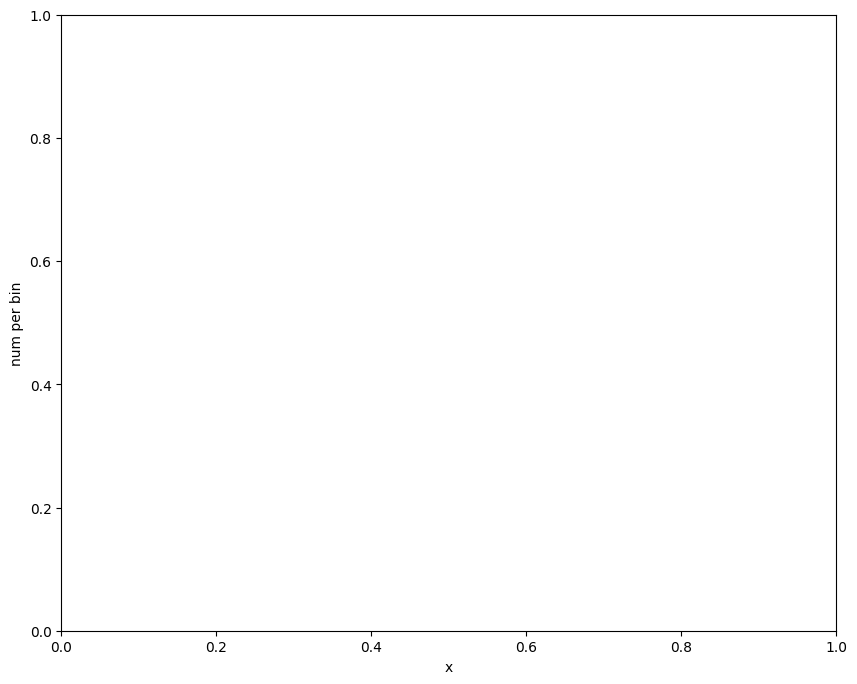

In [18]:
ax.set_yscale('log')
ax.set_ylim(2000)

plt.xlabel('x')
plt.ylabel('num per bin')
plt.show()

### Using Chauvenet's Criterion

Below is an experiment to histogram the fluxes without outliers greater than 5 sig

In [19]:
from scipy.special import erf

In [20]:
#computes the probability of an event
#of magnitude x or greater from
#a gaussian distribution
def event_probability(x, mu=0.0, s=1.0):
    #x is the value of the event
    #mu is the gaussian mean (default 0.0)
    #s is the std dev (default 1.0)

    #s is how many sigma away x is from the mean
    z = np.fabs((x-mu)/s)

    return 1.0 - erf(z/np.sqrt(2))

In [21]:
def chauvenet_criterion(prior_measurements, outlier):
    #prior_measurements is our set of previous measurements
    #outlier is the value we want to check

    #returns True if the outlier can be discarded
    #returns False if the outlier cannot be immediately discarded

    #compute mean and std of prior measurements
    #and assume these are representative of the gaussian
    mean = np.mean(prior_measurements)
    std = np.std(prior_measurements)

    #compute the probability of the outlier
    outlier_probability = event_probability(outlier, mu=mean, s=std)

    #get the number of events, include new outlier
    N = len(prior_measurements) + 1

    #check Chauvenet's criterion
    if (N * outlier_probability < 0.5) :
        return True
    
    #if we are here in the code, then the above condition was false
    #we cannot discard the outlier
    return False

In [22]:
#Get mean and std of flux data
flux_mean = np.mean(flux)
flux_std = np.std(flux)

In [23]:
# Get all fluxes 5 sigma or more away from mean
sigma5_flux = [i for i in flux if ((i - flux_mean) / flux_std >= 4)]

In [24]:
checked_flux = [i for i in flux if chauvenet_criterion(flux, i) == False]


print(len(checked_flux))
print(max(checked_flux))

8630
35.85189163804054


In [33]:
#create the histogram bins
width = .05
histmin =  np.round((min(checked_flux)- flux_mean) / flux_std, 2) #round to closest smaller integer
histmax =  np.round((max(checked_flux) - flux_mean) / flux_std, 2) #round to closest higher integer

print(histmax, histmin)

3.84 -0.15


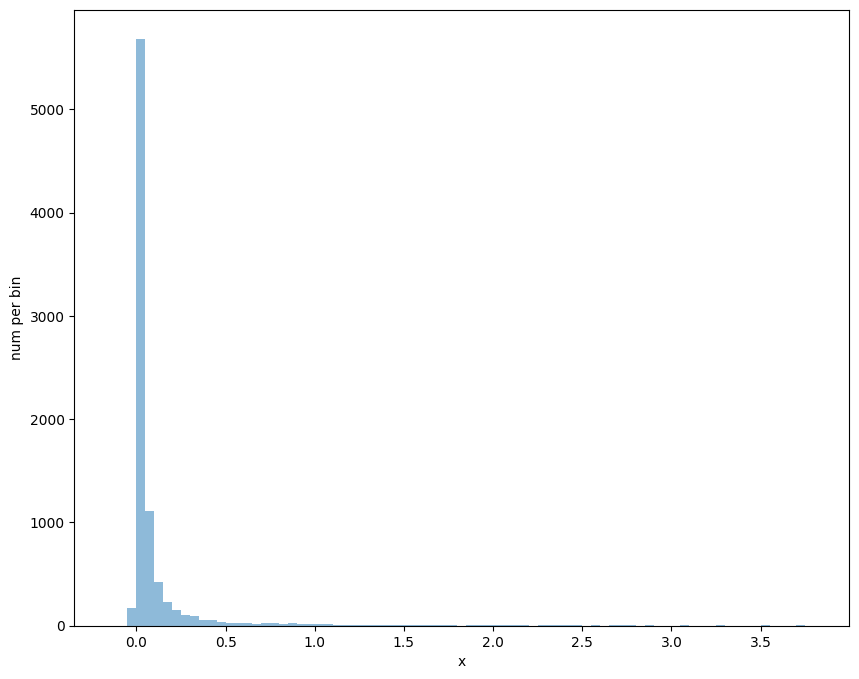

In [34]:
bins = np.arange(histmin, histmax, width)

#create historgram
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.hist(flux, bins = bins, alpha = 0.5, density=False)
# ax.set_yscale('log')

plt.xlabel('x')
plt.ylabel('num per bin')
plt.show()

## Statistical Info

What are the mean, median, and standard deviation of the distribution of fluxes?

In [60]:
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)

print(f'The mean of the distribution of the fluxes is {flux_mean}.')
print(f'The median of the distribution of the fluxes is {flux_median}.')
print(f'The standard deviation of the distribution of the fluxes is {flux_std}.')

The mean of the distribution of the fluxes is 0.7049841517197869.
The median of the distribution of the fluxes is 0.07388899756013416.
The standard deviation of the distribution of the fluxes is 13.027314980904412.


What is the largest outlier in the distribution?

In [ ]:
flux_max = np.max(flux)

print(f'The mean of the distribution of the fluxes is {flux_mean}.')

Where is the largest outlier on the image?

How many standard deviations is the largest outlier away from the mean?

## 3-color false image of the UDF using RGB

Make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.

In [250]:
# open fits file and read image data 
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits") as hdul:
    data1 = hdul[0].data

with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits") as hdul:
    data2 = hdul[0].data



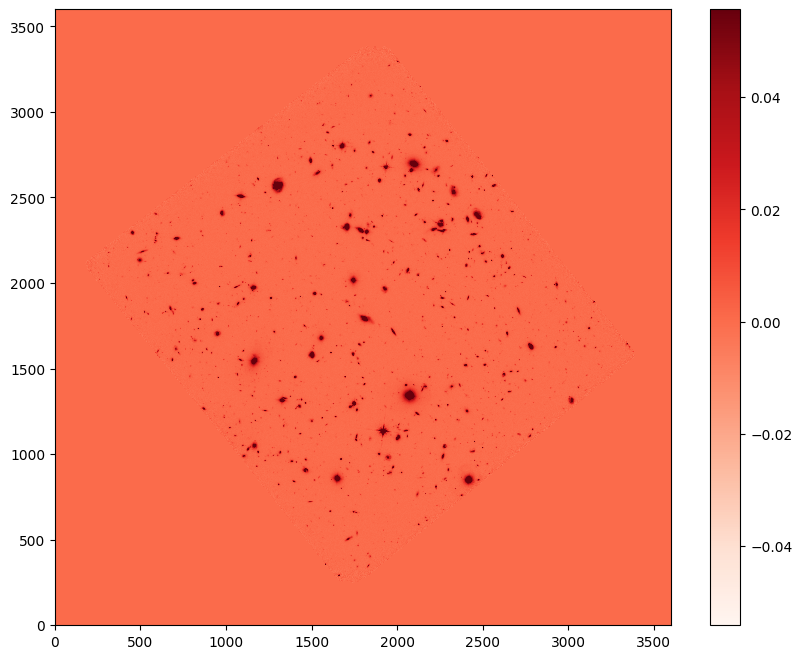

In [263]:
#imshow takes the image data, type of interpolation (estimation), a color map type,
#the data range that the color map covers (vmin to vmax)*,
#and where to place start the data from [0,0] of the image array
plt.imshow(data2, interpolation='nearest', alpha=1, cmap='Reds', vmin=m-s, vmax=m+s, origin='lower')
# plt.imshow(data1, interpolation='nearest', alpha=0.5, cmap='Greens', vmin=m-s, vmax=m+s, origin='lower')
# plt.imshow(data, interpolation='nearest', alpha=0.5, cmap='Blues', vmin=m-s, vmax=m+s, origin='lower')


#display a colorbar
plt.colorbar();

# *here they are calculated by +/- one std from the mean

plt.savefig('3-color-false-image.png', bbox_inches='tight')